# _Please make sure the previous Endpoints are deleted before proceeding.  Otherwise, you might see a `ResourceLimitExceeded` error._


# Perform A/B Test using REST Endpoints

You can test and deploy new models behind a single SageMaker Endpoint with a concept called “production variants.” These variants can differ by hardware (CPU/GPU), by data (comedy/drama movies), or by region (US West or Germany North). You can shift traffic between the models in your endpoint for canary rollouts and blue/green deployments. You can split traffic for A/B tests. And you can configure your endpoint to automatically scale your endpoints out or in based on a given metric like requests per second. As more requests come in, SageMaker will automatically scale the model prediction API to meet the demand.

<img src="img/model_ab.png" width="80%" align="left">

We can use traffic splitting to direct subsets of users to different model variants for the purpose of comparing and testing different models in live production. The goal is to see which variants perform better. Often, these tests need to run for a long period of time (weeks) to be statistically significant. The figure shows 2 different recommendation models deployed using a random 50-50 traffic split between the 2 variants.

In [1]:
!pip install -q --upgrade pip
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0
!pip install -q transformers==2.8.0

In [2]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [3]:
%store -r training_job_name

In [4]:
print(training_job_name)

tensorflow-training-2020-06-06-15-43-12-549


# Copy the Model to the Notebook

In [5]:
#!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz ./model.tar.gz

In [6]:
#!tar -xvzf ./model.tar.gz

# Show the Prediction Signature

In [7]:
#!saved_model_cli show --all --dir ./tensorflow/saved_model/0/

In [8]:
import boto3
client = boto3.client("sagemaker")

# Create Variant A Model From the Training Job in a Previous Section

Notes:
* `primary_container_image` is required because the inference and training images are different.
* By default, the training image will be used, so we need to override it.  
* See https://github.com/aws/sagemaker-python-sdk/issues/1379
* If you are using Elastic Inference in the variant, you need to point to the Elastic Inference image
* If you are not using a US-based region, you may need to adapt the container image to your current region using the following table:

https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html

In [9]:
import time
timestamp = '{}'.format(int(time.time()))

model_a_name = '{}-{}-{}'.format(training_job_name, 'var-a', timestamp)

sess.create_model_from_job(name=model_a_name,
                           training_job_name=training_job_name,
                           role=role,
                           primary_container_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-inference:2.1.0-cpu-py36-ubuntu18.04'.format(region))
 #                           primary_container_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-inference-eia:2.0.0-cpu-py36-ubuntu18.04'.format(region))


'tensorflow-training-2020-06-06-15-43-12-549-var-a-1595093399'

# Create Variant B Model From the Training Job in a Previous Section
Notes:
* This is the same underlying model as variant A, but does not use an attached Elastic Inference Adapter (EIA).
* `primary_container_image` is required because the inference and training images are different.
* By default, the training image will be used, so we need to override it.  
* See https://github.com/aws/sagemaker-python-sdk/issues/1379
* If you are not using a US-based region, you may need to adapt the container image to your current region using the following table:

https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html

In [10]:
model_b_name = '{}-{}-{}'.format(training_job_name, 'var-b', timestamp)

sess.create_model_from_job(name=model_b_name,
                           training_job_name=training_job_name,
                           role=role,
                           primary_container_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-inference:2.1.0-cpu-py36-ubuntu18.04'.format(region))


'tensorflow-training-2020-06-06-15-43-12-549-var-b-1595093399'

# Canary Rollouts and A/B Testing

Canary rollouts are used to release new models safely to only a small subset of users such as 5%. They are useful if you want to test in live production without affecting the entire user base. Since the majority of traffic goes to the existing model, the cluster size of the canary model can be relatively small since it’s only receiving 5% traffic.

Instead of `deploy()`, we can create an `Endpoint Configuration` with multiple variants for canary rollouts and A/B testing.

In [11]:
from sagemaker.session import production_variant

variantA = production_variant(model_name=model_a_name,
                              instance_type="ml.m5.large",
                              initial_instance_count=1,
                              variant_name='VariantA',
#                              accelerator_type='ml.eia2.medium',
                              initial_weight=50)
variantB = production_variant(model_name=model_b_name,
                              instance_type="ml.m5.large",
                              initial_instance_count=1,
                              variant_name='VariantB',
                              initial_weight=50)

In [12]:
import time
timestamp = '{}'.format(int(time.time()))

endpoint_config_name = '{}-{}'.format(training_job_name, timestamp)

endpoint_config = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[variantA, variantB])

In [13]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpointConfig/{}">REST Endpoint Configuration</a></b>'.format(region, endpoint_config_name)))


In [14]:
endpoint_name = '{}-{}'.format(training_job_name, timestamp)

endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)

In [15]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(region, endpoint_name)))


# _Wait Until the ^^ Endpoint ^^ is Deployed_

In [16]:
client = boto3.client('sagemaker')
waiter = client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

# Simulate a Prediction from an Application

## Setup the Request Handler to Convert Raw Text into BERT Tokens

In [17]:
class RequestHandler(object):
    import json
    
    def __init__(self, tokenizer, max_seq_length):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __call__(self, instances):
        transformed_instances = []

        for instance in instances:
            encode_plus_tokens = tokenizer.encode_plus(instance,
                                                       pad_to_max_length=True,
                                                       max_length=self.max_seq_length)

            input_ids = encode_plus_tokens['input_ids']
            input_mask = encode_plus_tokens['attention_mask']
            segment_ids = [0] * self.max_seq_length

            transformed_instance = {"input_ids": input_ids, 
                                    "input_mask": input_mask, 
                                    "segment_ids": segment_ids}

            transformed_instances.append(transformed_instance)

        transformed_data = {"instances": transformed_instances}

        return json.dumps(transformed_data)

## Setup the Response Handler to Convert the BERT Response into Our Predicted Classes

In [18]:
class ResponseHandler(object):
    import json
    import tensorflow as tf
    
    def __init__(self, classes):
        self.classes = classes
    
    def __call__(self, response, accept_header):
        import tensorflow as tf

        response_body = response.read().decode('utf-8')

        response_json = json.loads(response_body)

        log_probabilities = response_json["predictions"]

        predicted_classes = []

        # Convert log_probabilities => softmax (all probabilities add up to 1) => argmax (final prediction)
        for log_probability in log_probabilities:
            softmax = tf.nn.softmax(log_probability)    
            predicted_class_idx = tf.argmax(softmax, axis=-1, output_type=tf.int32)
            predicted_class = self.classes[predicted_class_idx]
            predicted_classes.append(predicted_class)

        return predicted_classes

## Instantiate the Request/Response Handler Classes Above

In [19]:
import json
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

request_handler = RequestHandler(tokenizer=tokenizer,
                                 max_seq_length=128)

response_handler = ResponseHandler(classes=[1, 2, 3, 4, 5])

## Instantiate the Predictor with our Endpoint

In [20]:
from sagemaker.tensorflow.serving import Predictor

predictor = Predictor(endpoint_name=endpoint_name,
                      sagemaker_session=sess,
                      serializer=request_handler,
                      deserializer=response_handler,
                      content_type='application/json',
                      model_name='saved_model',
                      model_version=0)

In [70]:
print(type(predictor))

<class 'sagemaker.tensorflow.serving.Predictor'>


In [66]:
#!pip install -q sagemaker==1.69.0

In [73]:
import tensorflow as tf
import json
    
reviews = ["This is great!", 
           "This is not good."]

predicted_classes = predictor.predict(reviews)
print(predicted_classes)

for predicted_class, review in zip(predicted_classes, reviews):
    print('[Predicted Star Rating: {}]'.format(predicted_class), review)

[5, 5]
[Predicted Star Rating: 5] This is great!
[Predicted Star Rating: 5] This is not good.


## Run Inferences Against Our Dataset

In [132]:
import csv
df_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')
df_reviews.shape

(102084, 15)

In [133]:
df_sample_reviews = df_reviews[['review_body', 'star_rating']].sample(n=100)
df_sample_reviews.shape

(100, 2)

In [131]:
import pandas as pd

def predict(review_body):
    return predictor.predict([review_body])[0]

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

y_pred = df_sample_reviews['review_body'].map(predict)

print("Done!")

y_pred.head()

Sending test traffic to the endpoint tensorflow-training-2020-06-06-15-43-12-549-1595093410. 
Please wait...
Done!


976      5
54354    5
57431    4
69665    4
71696    4
Name: review_body, dtype: int64

# Review the REST Endpoint Performance Metrics

### Invocations per variant

Amazon SageMaker emits metrics such as Latency and Invocations (full list of metrics [here](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)) for each variant in Amazon CloudWatch. Let’s query CloudWatch to get number of Invocations per variant, to show how invocations are split across variants:

In [134]:
from datetime import datetime, timedelta
import time
import pandas as pd

cw = boto3.Session().client("cloudwatch")

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop("Unit", axis=1)\
            .rename(columns={"Sum": variant_name})

def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variantA = get_invocation_metrics_for_endpoint_variant(endpoint_name, variantA["VariantName"], start_time, end_time)
    metrics_variantB = get_invocation_metrics_for_endpoint_variant(endpoint_name, variantB["VariantName"], start_time, end_time)
    metrics_variants = metrics_variantA.join(metrics_variantB, how="outer")
    metrics_variants.plot()
    return metrics_variants

In [136]:
%%time
%matplotlib inline

print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

Waiting a minute for initial metric creation...


KeyError: 'Timestamp'

## Invoke a specific variant

You can also use feature `TargetVariant` to invoke a specific variant. With this, we simply define which specific ProductionVariant we want to invoke:

```
response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                       ContentType="text/csv",
                                       Body=payload,
                                       TargetVariant=variantA["VariantName"])
```

# Shift All Traffic to Variant B
_**No downtime** occurs during this traffic-shift activity._

This may take a few minutes.  Please be patient.

In [34]:
updated_endpoint_config = [
    {
        'VariantName': 'VariantA',
        'DesiredWeight': 0,
    },
    {
        'VariantName': 'VariantB',
        'DesiredWeight': 100,
    }
]

In [35]:
client.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=updated_endpoint_config
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:806570384721:endpoint/tensorflow-training-2020-06-06-15-43-12-549-1595093410',
 'ResponseMetadata': {'RequestId': '93f14697-1d66-4920-88da-3f26c08e41a6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '93f14697-1d66-4920-88da-3f26c08e41a6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '122',
   'date': 'Sat, 18 Jul 2020 17:57:05 GMT'},
  'RetryAttempts': 0}}

In [36]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(region, endpoint_name)))


# _Wait for the ^^ Endpoint Update ^^ to Complete Above_
This may take a few minutes.  Please be patient.

In [37]:
client = boto3.client('sagemaker')
waiter = client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

# Check the REST Endpoint Performance Metrics

In [44]:
import numpy as np
predictions = []

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open('data/amazon_reviews_us_Digital_Software_sample.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        star_review = row.rstrip('\n')
        payload = star_review[2:]
        payload = payload.replace('"', '')
        payload_arr = [payload]
        # print('Payload: ' + payload)
        response = predictor.predict(payload_arr)
        #predictions = ','.join([predictions, response['Body'].read().decode('utf-8')])
        predictions.append(response[0])
time.sleep(0.5)
#print(predictions)

print("Done!") 

Sending test traffic to the endpoint tensorflow-training-2020-06-06-15-43-12-549-1595093410. 
Please wait...
.....Done!


,VariantA,VariantB
Timestamp,,
2020-07-18 17:37:00+00:00,4.0,2.0
2020-07-18 17:52:00+00:00,1.0,4.0
2020-07-18 17:54:00+00:00,1.0,NaN
2020-07-18 18:13:00+00:00,NaN,10.0


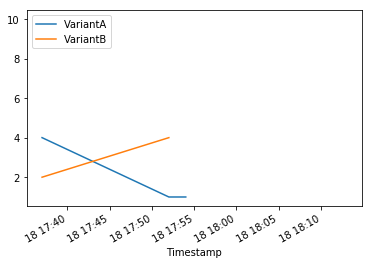

In [45]:
time.sleep(20) #let metrics catch up
plot_endpoint_metrics()

# Evaluate variant performance
Let's evaluate the accuracy, precision, recall, F1 score, and ROC/AUC for VariantB:

In [ ]:
import csv

df = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                 delimiter='\t', 
                 quoting=csv.QUOTE_NONE,
                 compression='gzip')
df.shape

In [47]:
import csv

df = pd.read_csv('./data/amazon_reviews_us_Digital_Software_sample.csv', 
                 delimiter='\t', 
                 quoting=csv.QUOTE_NONE)
df.shape

(4, 1)

In [33]:
#time.sleep(20) #let metrics catch up
#plot_endpoint_metrics()

In [40]:
df_labels = df[['star_rating']]
df_labels.shape

(102084, 1)

# Remove Variant A to Reduce Cost
Modify the Endpoint Configuration to only use variant B.

_**No downtime** occurs during this scale-down activity._

This may take a few mins.  Please be patient.

In [ ]:
import time
timestamp = '{}'.format(int(time.time()))

updated_endpoint_config_name = '{}-{}'.format(training_job_name, timestamp)

updated_endpoint_config = client.create_endpoint_config(
    EndpointConfigName=updated_endpoint_config_name,
    ProductionVariants=[
        {
         'VariantName': 'VariantB',
         'ModelName': model_b_name,  # Only specify variant B to remove variant A
         'InstanceType':'ml.m5.large',
         'InitialInstanceCount': 1,
         'InitialVariantWeight': 100
        }
    ])

In [ ]:
client.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=updated_endpoint_config_name
)

# _If You See An ^^ Error ^^ Above, Please Wait Until the Endpoint is Updated_

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(region, endpoint_name)))


In [ ]:
model_ab_endpoint = endpoint_name

In [ ]:
%store model_ab_endpoint

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();